## Dataset download ##

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import tarfile
import random
import time
import glob
import json
from pathlib import Path

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.dentexdata import DentexData
from dentexmodel.fileutils import FileOP
from dentexmodel.imageproc import ImageData

print(f'Project module version: {dm.__version__}')

Project module version: 0.0.post1.dev91+gcf6c759.d20240202


### Download the classification data set ###
Full data set: https://zenodo.org/records/7812323/files/training_data.zip?download=1

In [2]:
# Download directory (change as needed)
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
data_dir = os.path.join(dentex_dir, 'dentex_classification')
Path(data_dir).mkdir(parents=True, exist_ok=True)

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')

# Create an instance of the DentexData class
dtx = DentexData(data_dir=data_dir)
sz = FileOP().file_size_from_url(dtx.classification_url)/1024/1024

# Download and extract the data
print(f'Downloading {sz:.0f} MiB from:\n{dtx.classification_url}')
data_tar_file = dtx.download_image_data()

# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
print(f'Extracted {len(file_list)} images.')

https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration-disease.tar.gz
Extracting from .gz archive.
Uncompressed output file exists: /app/data/dentex/dentex_classification/dentex-quadrant-enumeration-disease.tar. Skipping.
Extracted 705 images.


In [3]:
# Create a data frame with the image file paths
file_name_list = [os.path.basename(file) for file in file_list]
im_number_list = [int(os.path.splitext(file)[0].rsplit('_', maxsplit=1)[-1]) for file in file_name_list]
files = pd.DataFrame({'image_number': im_number_list,
                      'file_name': file_name_list,
                      'file_path': file_list}).\
                sort_values(by='image_number', ascending=True).reset_index(drop=True)

display(files.head())

,image_number,file_name,file_path
0,0,train_0.png,/app/data/dentex/dentex_classification/quadran...
1,1,train_1.png,/app/data/dentex/dentex_classification/quadran...
2,2,train_2.png,/app/data/dentex/dentex_classification/quadran...
3,3,train_3.png,/app/data/dentex/dentex_classification/quadran...
4,4,train_4.png,/app/data/dentex/dentex_classification/quadran...


In [4]:
# Load the annotation file
annotation_file = os.path.join(data_dir, 
                               'quadrant-enumeration-disease', 
                               'train_quadrant_enumeration_disease.json')
annotations = dtx.load_annotations(annotation_file)
print(f'Loaded annotations from file:\n{dtx.annotations_file}\n{annotations.keys()}')

Loaded annotations from file:
/app/data/dentex/dentex_classification/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json
dict_keys(['images', 'annotations', 'categories_1', 'categories_2', 'categories_3'])


In [5]:
# Add image ids to the files data frame
js_im_df = pd.DataFrame(annotations.get('images')).\
                merge(files, on='file_name', how='inner').\
                sort_values(by='id', ascending=True).\
                reset_index(drop=True).\
                rename(columns={'id': 'image_id'}).\
                drop(['height', 'width'], axis=1)
display(js_im_df.head())
print(js_im_df.shape)

,image_id,file_name,image_number,file_path
0,1,train_673.png,673,/app/data/dentex/dentex_classification/quadran...
1,2,train_283.png,283,/app/data/dentex/dentex_classification/quadran...
2,3,train_435.png,435,/app/data/dentex/dentex_classification/quadran...
3,4,train_95.png,95,/app/data/dentex/dentex_classification/quadran...
4,5,train_475.png,475,/app/data/dentex/dentex_classification/quadran...


(705, 4)


### Disease categories ###

In [6]:
# Create a dictionary of categories with IDs and names
# The categories are described in a dictionary at the top of the JSON file
display(dtx.annotations.keys())
print()
# We can create one dictionary with the labels for each annotation
categories = dtx.create_category_dict()
display(categories)

dict_keys(['images', 'annotations', 'categories_1', 'categories_2', 'categories_3'])

{'categories_1': {0: '1', 1: '2', 2: '3', 3: '4'},
 'categories_2': {0: '1',
  1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8'},
 'categories_3': {0: 'Impacted',
  1: 'Caries',
  2: 'Periapical Lesion',
  3: 'Deep Caries'}}

### Transfer annotations from json file into a data frame ###
The data frame format is needed to create the classification data set

In [7]:
# Loop over the annotations
an_df_list = []
for idx, an_dict in enumerate(annotations.get('annotations')):
    if (idx + 1) % 500 == 0:
        print(f'Annotation {idx + 1} / {len(annotations.get("annotations"))}')
    
    image_id = an_dict.get('image_id')
    id_df = js_im_df.loc[js_im_df['image_id'] == image_id]
    
    # Find the quadrant, tooth position and disease categories for this annotation
    quadrant_id = an_dict.get('category_id_1')
    quadrant = categories.get('categories_1').get(quadrant_id)
    
    position_id = an_dict.get('category_id_2')
    position = categories.get('categories_2').get(position_id)
    
    disease_id = an_dict.get('category_id_3')
    disease = categories.get('categories_3').get(disease_id)
    
    id_df = id_df.assign(quadrant=quadrant,
                         position=position,
                         label=disease,
                         cl = disease_id,
                         area=[an_dict.get('area')],
                         bbox=[an_dict.get('bbox')],
                         box_name=(f'{os.path.splitext(id_df["file_name"].values[0])[0]}_'
                                   f'{idx}_{quadrant}_{position}'))    
    an_df_list.append(id_df)
an_df = pd.concat(an_df_list, axis=0, ignore_index=True)

# Add the number of annotations to each image
n_annotations = an_df[['file_name', 'label']].\
                groupby('file_name').count().\
                reset_index(drop=False).\
                rename(columns={'label': 'annotations'})

an_df = an_df.merge(n_annotations, on='file_name', how='inner').\
                sort_values(by='image_id', ascending=True).\
                reset_index(drop=True)

print()
display(an_df.head())

Annotation 500 / 3529
Annotation 1000 / 3529
Annotation 1500 / 3529
Annotation 2000 / 3529
Annotation 2500 / 3529
Annotation 3000 / 3529
Annotation 3500 / 3529



,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations
0,1,train_673.png,673,/app/data/dentex/dentex_classification/quadran...,4,8,Impacted,0,39683,"[542.0, 698.0, 220.0, 271.0]",train_673_0_4_8,13
1,1,train_673.png,673,/app/data/dentex/dentex_classification/quadran...,4,1,Periapical Lesion,2,21469,"[1288.3116883116884, 723.3766233766233, 62.337...",train_673_12_4_1,13
2,1,train_673.png,673,/app/data/dentex/dentex_classification/quadran...,3,2,Periapical Lesion,2,22286,"[1405.1948051948052, 724.6753246753246, 75.324...",train_673_10_3_2,13
3,1,train_673.png,673,/app/data/dentex/dentex_classification/quadran...,3,7,Caries,1,42235,"[1806.0, 696.0, 237.0, 308.0]",train_673_9_3_7,13
4,1,train_673.png,673,/app/data/dentex/dentex_classification/quadran...,3,6,Caries,1,46556,"[1667.0, 723.0, 237.0, 356.0]",train_673_8_3_6,13


### Plot some images with annotations ###

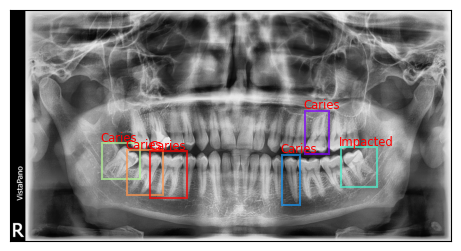

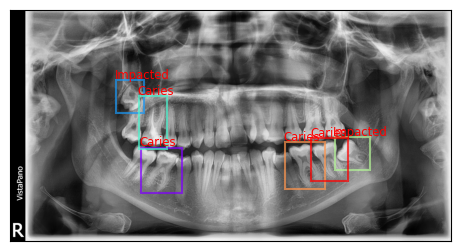

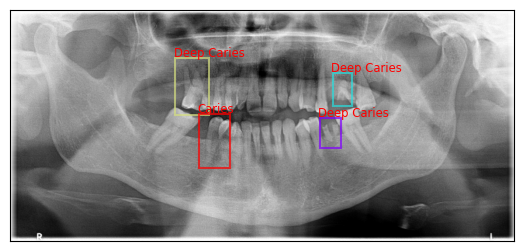

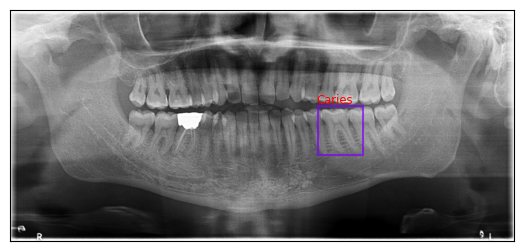

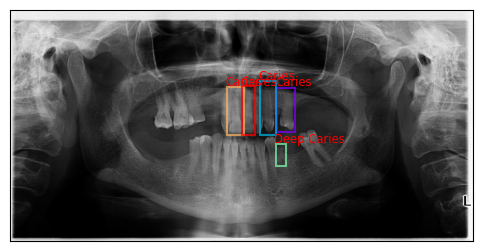

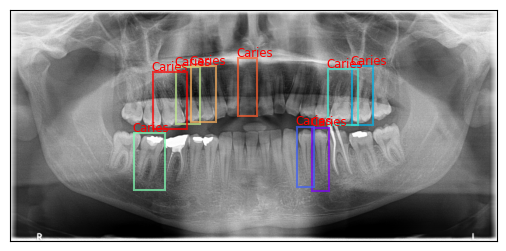

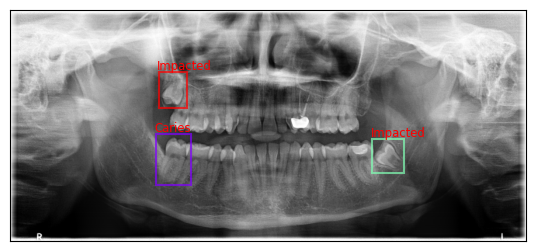

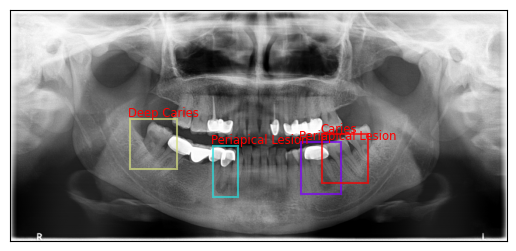

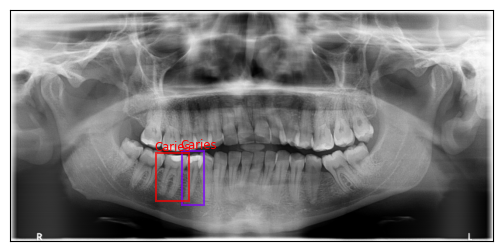

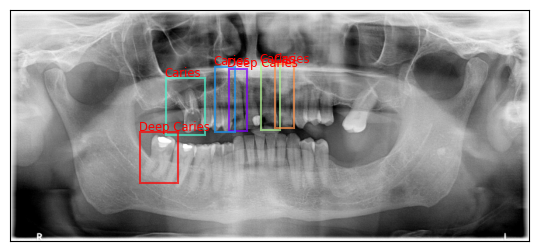

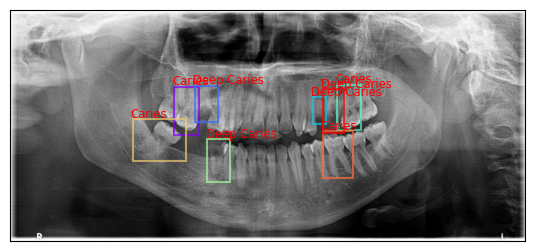

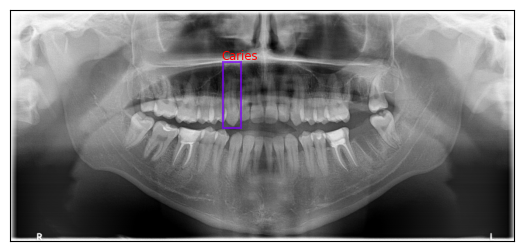

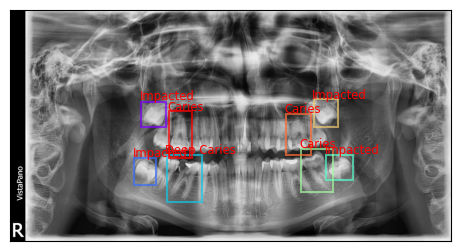

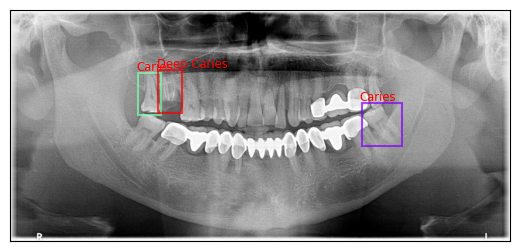

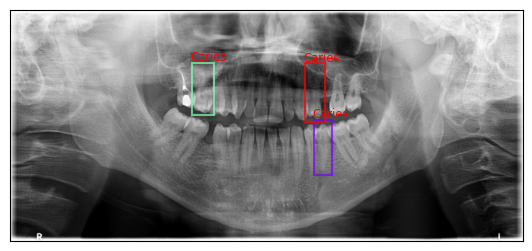

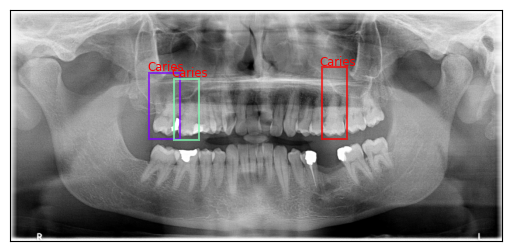

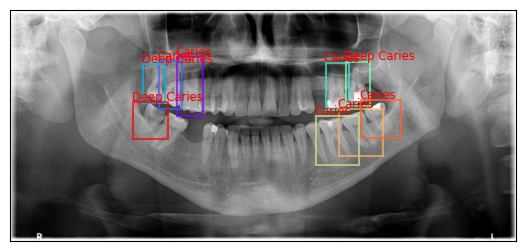

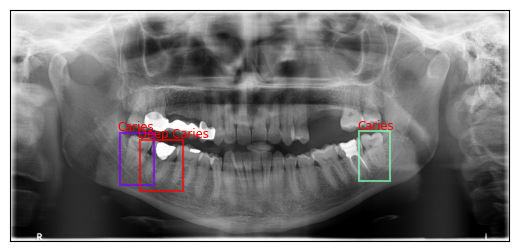

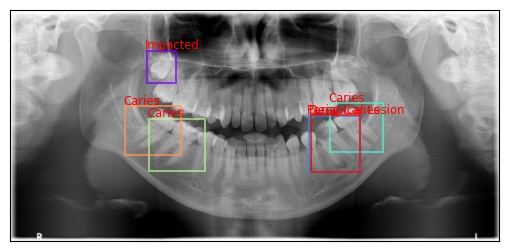

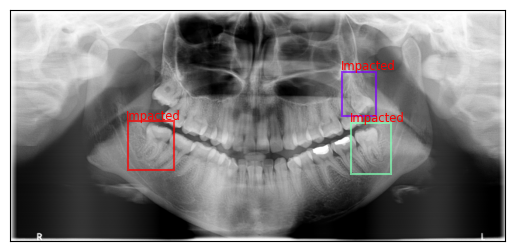

In [8]:
# Show an xray image with bounging boxes
np.random.seed(123)
file_name_list = np.random.choice(an_df['file_name'].unique(), size=20, replace=False)
#file_name_list = ['train_265.png', 'train_269.png', 'train_270.png']
for file_name in file_name_list:
    an_file_df = an_df.loc[(an_df['file_name'] == file_name)] 
    #                        (an_df['position'] == '6') &
    #                        (an_df['quadrant'] == '4')]
    
    file = os.path.join(image_dir, file_name)
    im = ImageData().load_image(file)
    #im = ImageData().hist_eq(im)
    
    # Create a list of colors for the rectangles
    color = cm.rainbow(np.linspace(0, 1, len(an_file_df)))
    color_list = [color[c] for c in range(len(color))]
    text_offset_xy = (-10, -10)
    
    # Create the figure and show the panoramic x-ray image
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(im)
    
    # Loop over the bounding boxes
    for i, idx in enumerate(an_file_df.index): 
    
        box_df = an_file_df.loc[an_file_df.index==idx]
        
        box = box_df['bbox'].values[0]
        bbox = box[0], box[1], box[0] + box[2], box[1] + box[3]
        label = box_df['label'].values[0]
        
        
        rect = patches.Rectangle(xy=(box[0], box[1]), width=box[2], height=box[3], 
                                         linewidth=1.5, edgecolor=color_list[i], 
                                         facecolor='none', alpha=0.7)
        ax.add_patch(rect)
        
        ax.text(box[0]+text_offset_xy[0], 
                box[1]+text_offset_xy[1]+i, 
                label, 
                color='r',
                fontsize='small',
                fontweight='medium')
        
        ax.set(xticks=[], yticks=[])


    image_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
    plt.savefig(os.path.join(dentex_dir, image_name), bbox_inches='tight')
    plt.show()

In [9]:
# Save the data frame with the file paths and annotations
df_file_name = 'dentex_disease_dataset.parquet'
df_file = os.path.join(dentex_dir, df_file_name)
an_df.to_parquet(df_file)
print(f'Annotation data frame saved: {df_file}')

Annotation data frame saved: /app/data/dentex/dentex_disease_dataset.parquet
